## Sources
* Data: https://www.ntia.doc.gov/page/download-digital-nation-datasets
* Map (useful for checks!): https://www.ntia.doc.gov/data/digital-nation-data-explorer#sel=internetAtHome&disp=map
* Docs: https://www.ntia.doc.gov/files/ntia/publications/november-2019-techdocs.pdf
* Universes: https://www.ntia.doc.gov/files/ntia/data_central_downloads/code/create-ntia-tables-stata.zip

#### Useful variables:

peinhome, peinwork, pemphone, pemphone, hemobdat, hehomte1, hefaminc, pesex, prtage, peeduca, ptdtrace, prdthsp, prnmchld, gestfips

### Which weights?

For the weights, the 2019 sample documentation suggests `PWSSWGT` and `HWHHWGT` by default, and `PWPRMWGT` for the personal questions.  Let's just check this.

In [3]:
cps_test = pd.read_csv("data/nov19-cps.csv")

# Californian people...
ca_people = cps_test.query("(gestfips == 6) & (prtage >= 3) & (prpertyp != 3)")

ca_people.query("peinhome == 1").pwprmwgt.sum() / ca_people.pwprmwgt.sum(), \
ca_people.query("peinhome == 1").pwsswgt.sum()  / ca_people.pwsswgt.sum()

(0.9328654188139469, 0.7235029866408134)

If we exampine the [NTIA site](https://www.ntia.doc.gov/data/digital-nation-data-explorer#sel=homeInternetUser&disp=map), the number for California in 2019 is 72.4%.  So `pwsswgt` is right in this case -- it is not strictly within the used services category (email, texts, social, video, etc.).  Pay attention to exactly what it takes to reproduce the results on the official site.

### The issue with San Francisco.

Now let's check in on CA and SF households.  We will contrast the 

In [8]:
cps_test = pd.read_csv("data/nov19-cps.csv")

# Householders
cps_test["isHouseholder"] = (cps_test.perrp > 0) & (cps_test.perrp < 3) & \
                            (cps_test.hrhtype > 0) & (cps_test.hrhtype < 9)

# Households in California, and those in SF county/city.
ca_households = cps_test.query("(gestfips == 6) & isHouseholder")
sf_households = ca_households.query("gtco == 75")

# Get the "official" estimate and compare to our calculted quantity for CA, 
#   and then SF (no official available)
ca_ntia_official = 0.799
ca_internet = ca_households.query("heinhome == 1").hwhhwgt.sum() / ca_households.hwhhwgt.sum()
sf_internet = sf_households.query("heinhome == 1").hwhhwgt.sum() / sf_households.hwhhwgt.sum()

ca_ntia_official, ca_internet, sf_internet

(0.799, 0.7992982448757221, 0.6540205571069156)

Are the errors just enormous??

In [9]:
hh               = sf_households.filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()
hh_with_internet = sf_households.query("heinhome == 1").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()

sf_internet_reps = hh_with_internet / hh

np.sqrt((4 / 160) * ((sf_internet_reps - sf_internet)**2).sum())

0.049732365088150265

So I exactly reproduce the "correct" answer, but SF county shows up as quite significantly lower internet use at home than the rest of CA.

This simply does not feel correct to me.

### Constructed variables.

For reference, see the stata code by Rafi Goldberg, <rgoldberg@ntia.doc.gov>

In [43]:
cps = pd.read_csv("data/nov19-cps.csv")
#cps.query("pwsswgt > 0")

# We can get these later for standard errors...
# cps = cps.filter(regex = "^((?!wgt[0-9]).)*$", axis = 1)

## Demographics 
ed_map = {-1 : "", 31 : "No Diploma", 32 : "No Diploma", 33 : "No Diploma", 34 : "No Diploma",
          35 : "No Diploma", 36 : "No Diploma", 37 : "No Diploma", 38 : "No Diploma",
          39 : "High School", 40 : "Some College or Associates", 41 : "Some College or Associates", 42 : "Some College or Associates",
          43 : "College or Higher", 44 : "College or Higher", 45 : "College or Higher", 46 : "College or Higher"}

cps["education"] = cps.peeduca.replace(ed_map)

## Construct all the universe, following their cuts.
cps["isPerson"]      = (cps.prtage >= 3) & (cps.prpertyp != 3)
cps["isHouseholder"] = (cps.perrp > 0) & (cps.perrp < 3) & (cps.hrhtype > 0) & (cps.hrhtype < 9)
cps["isAdult"]       = cps.isPerson & (cps.prtage >= 15)
cps["isRespondent"]  = cps.puelgflg == 20

cps["P_at_home"]     = np.where(cps.isPerson, cps.peinhome == 1, np.nan)
cps["P_at_work"]     = np.where(cps.isPerson, cps.peinwork == 1, np.nan)
cps["P_at_school"]   = np.where(cps.isPerson, cps.peinschl == 1, np.nan)
cps["P_anywhere"]    = np.where(cps.isPerson, 
                                (cps.peinhome == 1) | (cps.peinwork == 1) | (cps.peinschl == 1) | \
                                (cps.peincafe == 1) | (cps.peintrav == 1) | (cps.peinlico == 1) | \
                                (cps.peinelho == 1) | (cps.peinothr == 1), 
                                np.nan)

cps["P_mobdat"]      = np.where(cps.isPerson, cps.hemobdat == 1, np.nan)

cps["P_computer"]    = np.where(cps.isPerson, (cps.pelaptop == 1) | (cps.pedesktp == 1), np.nan)
cps["P_smartphone"]  = np.where(cps.isPerson, cps.pemphone == 1, np.nan)

cps["P_email"]       = np.where(cps.isPerson, cps.peemail == 1, np.nan)
cps["P_text"]        = np.where(cps.isPerson, cps.petextim == 1, np.nan)
cps["P_social"]      = np.where(cps.isPerson, cps.pesocial == 1, np.nan)
cps["P_video"]       = np.where(cps.isPerson, cps.pevideo == 1, np.nan)
cps["P_services"]    = np.where(cps.isPerson, cps.peusesvc == 1, np.nan)


cps["H_at_home"]     = np.where(cps.isHouseholder, cps.heinhome == 1, np.nan)
cps["H_anywhere"]    = np.where(cps.isHouseholder, 
                                (cps.heinhome == 1) | (cps.heinwork == 1) | (cps.heinschl == 1) | \
                                (cps.heincafe == 1) | (cps.heintrav == 1) | (cps.heinlico == 1) | \
                                (cps.heinelho == 1) | (cps.heinothr == 1), 
                                np.nan)

# Reaons for non-use.
cps["H_nonuse_cost"] = np.where(cps.isHouseholder, cps.heprinoh.isin([2, 3]), np.nan)
cps["H_nonuse_no_interest"] = np.where(cps.isHouseholder, cps.heprinoh == 1, np.nan)
cps["H_nonuse_not_available"] = np.where(cps.isHouseholder, cps.heprinoh == 5, np.nan)

cps["H_smartphone"]  = cps.hemphone == 1
cps["H_computer"]    = (cps.helaptop == 1) | (cps.hedesktp == 1)

## NTIA constructs these as high speed conditional on internet, 
##   which I think is less useful than the non-conditional ACS construction, 
##   but we can do this to get their numbers.
HIGH_SPEED_CONDITIONAL = False
if HIGH_SPEED_CONDITIONAL:
    cps["H_highsp"] = np.where(cps.isHouseholder & (cps.H_anywhere == True), cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder & (cps.H_at_home  == True), cps.hemobdat == 1, np.nan)
else:
    cps["H_highsp"] = np.where(cps.isHouseholder, cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder, cps.hemobdat == 1, np.nan)

How many people are in the sample?

In [2]:
(cps_test.pwsswgt > 0).sum()

117674

### Lots of contortions to get Census places.

Start with states, so we can check against "official" sources.

In [44]:
import psycopg2
from netrc import netrc

user, acct, passwd = netrc().authenticators("harris")

cen_con = psycopg2.connect(database = "census", user = user, password = passwd,
                           host = "localhost", port = 5432)

In [45]:
fips = pd.read_sql("SELECT fips, name FROM states;", index_col = "fips", con = cen_con).name.to_dict()
cps["state"] = cps.gestfips.replace(fips)

Population counts look right.

In [46]:
cps.groupby("state").pwsswgt.sum().loc[["Illinois", "California", "Pennsylvania"]] / 1e6

state
Illinois        12.497291
California      39.251506
Pennsylvania    12.622756
Name: pwsswgt, dtype: float64

### Construct city and CBSA populations.

In [47]:
cities = ["new_york", "los_angeles", "chicago", "houston", "phoenix",
          "philadelphia", "san_antonio", "san_diego", "dallas",
          "san_jose", "austin", "jacksonville", "san_francisco", "columbus",
          "fort_worth", "indianapolis", "charlotte", "seattle", "denver", "washington"]

city_dict = { # state, cbsa, city #
  "new_york"     : {"gestfips" : 36, "gtcbsa" : 35620, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "los_angeles"  : {"gestfips" :  6, "gtcbsa" : 31080, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  37}, 
  "chicago"      : {"gestfips" : 17, "gtcbsa" : 16980, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "houston"      : {"gestfips" : 48, "gtcbsa" : 26420, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "phoenix"      : {"gestfips" :  4, "gtcbsa" : 38060, "gtcbsast" : 1, "gtindvpc" : 1},
  "philadelphia" : {"gestfips" : 42, "gtcbsa" : 37980, "gtcbsast" : 1, "gtindvpc" : 0, "gtco" : 101},
  "san_antonio"  : {"gestfips" : 48, "gtcbsa" : 41700, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_diego"    : {"gestfips" :  6, "gtcbsa" : 41740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "dallas"       : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 1},
  "san_jose"     : {"gestfips" :  6, "gtcbsa" : 41940, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "austin"       : {"gestfips" : 48, "gtcbsa" : 12420, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "jacksonville" : {"gestfips" : 12, "gtcbsa" : 27260, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_francisco": {"gestfips" :  6, "gtcbsa" : 41860, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  75}, # SF county
  "columbus"     : {"gestfips" : 39, "gtcbsa" : 18140, "gtcbsast" : 1, "gtindvpc" : 0},
  "fort_worth"   : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 2}, 
  "indianapolis" : {"gestfips" : 18, "gtcbsa" : 26900, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "charlotte"    : {"gestfips" : 37, "gtcbsa" : 16740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "seattle"      : {"gestfips" : 53, "gtcbsa" : 42660, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "denver"       : {"gestfips" :  8, "gtcbsa" : 19740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "washington"   : {"gestfips" : 11, "gtcbsa" : 47900, "gtcbsast" : 1, "gtindvpc" : 1}
}

cps["city"] = ""
for city, vals in city_dict.items():
    
    query = " & ".join(["({} == {:})".format(k, v)
                        for k, v in vals.items()])
    
    cps.loc[cps.query(query).index, "city"] = city
    
cps_city = cps[cps.city != ""].copy()

In [48]:
cps[["city", "gestfips", "gtcbsa", "gtcsa", "gtmetsta", "gtcbsast", "gtindvpc", "gtco"]]\
   .query("(gestfips == 6) & (gtco == 75)").drop_duplicates().sort_values("city")

,city,gestfips,gtcbsa,gtcsa,gtmetsta,gtcbsast,gtindvpc,gtco
6460,san_francisco,6,41860,488,1,1,1,75


In [49]:
cbsa = ["new_york", "los_angeles", "chicago", "dallas-fort_worth", "houston", 
        "philadelphia", "washington", "miami", "atlanta", "boston", 
        "san_francisco", "riverside", "phoenix", "detroit", "seattle", 
        "minneapolis", "san_diego", "tampa", "st_louis", "baltimore"]

cbsa_dict = {
    35620 : "new_york", 31080 : "los_angeles", 16980 : "chicago", 19100 : "dallas-fort_worth", 26420 : "houston", 
    37980 : "philadelphia", 47900 : "washington", 33100 : "miami", 12060 : "atlanta", 14460 : "boston", 
    41860 : "san_francisco", 40140 : "riverside", 38060 : "phoenix", 19820 : "detroit", 42660 : "seattle", 
    33460 : "minneapolis", 41740 : "san_diego", 45300 : "tampa", 41180 : "st_louis", 12580 : "baltimore"
}

cps["cbsa"] = ""
cps.loc[cps.query("gtcbsa in @cbsa_dict").index, "cbsa"] = \
   cps.query("gtcbsa in @cbsa_dict").gtcbsa.replace(cbsa_dict)

cps_cbsa = cps[cps.cbsa != ""].copy()

In [50]:
# cps[["city", "gestfips", "gtcbsa", "gtcsa", "gtmetsta", "gtcbsast", "gtindvpc", "gtco"]]\
#    .query("city != ''").drop_duplicates().sort_values("city")

These populations seem about right... Washington DC is _way_ oversampled... weights are **necessary**.  In particular, San Francisco, where I had issues below is about 10% off of its "nominal" population (800k instead of 880k).

In [51]:
counts = cps_city.groupby("city").agg({"pwsswgt" : ["sum", "count"]})
counts.columns = ["cps_population", "N"]
city_populations = counts.sort_values(by = "cps_population", ascending = False)
city_populations

,cps_population,N
city,,
new_york,8.278783e+06,2281
los_angeles,4.074095e+06,1215
chicago,2.496310e+06,748
houston,2.191824e+06,591
san_antonio,1.851952e+06,497
philadelphia,1.645956e+06,418
phoenix,1.523442e+06,474
san_diego,1.292693e+06,374
fort_worth,1.138746e+06,272


(200,)

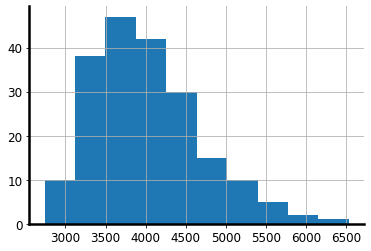

In [52]:
cps_city[(cps_city.city == "san_francisco") & (cps_city.pwsswgt > 0)].pwsswgt.hist()
cps_city[(cps_city.city == "san_francisco") & (cps_city.pwsswgt > 0)].pwsswgt.shape

### Construct the basic variables.

If the `HIGH_SPEED_CONDITIONAL` is true, this will give the NTIA results for states.

Internet in home.

In [53]:
def weighted_mean(G, w): return G._get_numeric_data().multiply(G[w],  axis=0).sum()/G[w].sum()

def access(df, grouper, HH = True, person = True):
    
    out_data = []
    
    if HH:
        
        hwss_vars =  df.query("isHouseholder").groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                       [["H_at_home", "H_mobdat", "H_highsp"]]

        hwss_vars_use =  df.query("isHouseholder & (H_at_home == False)")\
                           .groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                           [["H_nonuse_cost", "H_nonuse_no_interest", "H_nonuse_not_available"]]
        
        out_data.extend([hwss_vars, hwss_vars_use])

    if person:
        
        counts = df.query("isPerson").groupby(grouper).agg({"pwsswgt" : ["sum", "count"]})
        counts.columns = ["cps_population", "N"]
        
        pwss_vars =  df.query("isPerson").groupby(grouper).apply(weighted_mean, w = "pwsswgt")\
                       [["P_at_home", "P_at_work", "P_anywhere", "P_smartphone", "P_computer"]] 

        pwpr_vars =  df.query("isRespondent").groupby(grouper).apply(weighted_mean, w = "pwprmwgt")\
                       [["P_email", "P_text", "P_social", "P_video", "P_services"]]
        
        out_data.extend([counts, pwss_vars, pwpr_vars])
        
    complete = pd.concat(out_data, axis = 1).round(3)
        
    complete.index = complete.index.str.replace("_", " ").str.title()

    return complete.round(3)
    

### For comparison -- NTIA/Rafi Goldberg's results.

In [54]:
ntia_official = pd.read_csv("data/ntia-analyze-table_2020-05-15.csv")
ntia_official.query("dataset == 'Nov 2019'", inplace = True)
ntia_official.drop("dataset", axis = 1, inplace = True)
ntia_official.set_index("variable", inplace = True)
ntia_official = ntia_official.transpose()

### Demographics
Example is education level.

In [55]:
access(cps.query("prtage >= 15"), "education", HH = False)

,cps_population,N,P_at_home,P_at_work,P_anywhere,P_smartphone,P_computer,P_email,P_text,P_social,P_video,P_services
education,,,,,,,,,,,,
College Or Higher,8.480815e+07,31130,0.856,0.574,0.888,0.838,0.800,0.971,0.948,0.752,0.798,0.496
High School,7.209468e+07,27008,0.684,0.249,0.745,0.681,0.458,0.830,0.892,0.699,0.664,0.197
No Diploma,3.710227e+07,12954,0.623,0.089,0.689,0.634,0.394,0.733,0.879,0.719,0.727,0.133
Some College Or Associates,7.017797e+07,25835,0.807,0.393,0.850,0.797,0.690,0.938,0.932,0.758,0.748,0.333


In [56]:
ntia_official.loc[ntia_official.index.str.contains("^ed.*Prop$"), 
                  ["internetUser", "homeInternetUser"]]

variable,internetUser,homeInternetUser
edNoDiplomaProp,0.689243,0.623134
edHSGradProp,0.745495,0.683753
edSomeCollegeProp,0.849628,0.807262
edCollegeGradProp,0.888044,0.856397


Looks good.

### States

In [57]:
state_access = access(cps, "state")
state_access.sort_values("H_at_home", inplace = True)
state_access.style.background_gradient(cmap = "viridis")

,H_at_home,H_mobdat,H_highsp,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available,cps_population,N,P_at_home,P_at_work,P_anywhere,P_smartphone,P_computer,P_email,P_text,P_social,P_video,P_services
state,,,,,,,,,,,,,,,,,,
North Carolina,0.741000,0.655000,0.631000,0.225000,0.577000,0.012000,10009417.919000,2626,0.682000,0.279000,0.743000,0.640000,0.523000,0.863000,0.890000,0.718000,0.718000,0.248000
Mississippi,0.755000,0.695000,0.539000,0.191000,0.605000,0.070000,2820663.157000,2116,0.688000,0.226000,0.759000,0.643000,0.461000,0.824000,0.913000,0.775000,0.662000,0.135000
West Virginia,0.757000,0.651000,0.637000,0.223000,0.597000,0.033000,1702036.196000,2335,0.692000,0.240000,0.773000,0.609000,0.528000,0.847000,0.865000,0.741000,0.708000,0.133000
Louisiana,0.757000,0.707000,0.597000,0.186000,0.602000,0.047000,4377499.101000,2608,0.699000,0.278000,0.763000,0.668000,0.493000,0.850000,0.933000,0.752000,0.735000,0.225000
Tennessee,0.758000,0.718000,0.632000,0.266000,0.556000,0.031000,6511945.825000,2264,0.693000,0.287000,0.762000,0.639000,0.572000,0.859000,0.925000,0.737000,0.685000,0.291000
Kentucky,0.762000,0.706000,0.582000,0.206000,0.531000,0.034000,4265226.376000,1434,0.707000,0.304000,0.785000,0.664000,0.525000,0.855000,0.928000,0.766000,0.754000,0.217000
Wyoming,0.762000,0.644000,0.604000,0.195000,0.560000,0.074000,549533.430000,1650,0.731000,0.319000,0.791000,0.655000,0.562000,0.889000,0.921000,0.730000,0.728000,0.242000
Pennsylvania,0.763000,0.691000,0.682000,0.185000,0.563000,0.035000,12210669.074000,3125,0.718000,0.298000,0.768000,0.646000,0.576000,0.897000,0.920000,0.726000,0.758000,0.367000
New York,0.767000,0.693000,0.699000,0.135000,0.642000,0.006000,18440166.591000,4583,0.708000,0.297000,0.762000,0.646000,0.555000,0.890000,0.905000,0.721000,0.719000,0.370000


In [58]:
ntia_official.loc["CAProp", ["internetAtHome", "internetUser"]]

variable
internetAtHome    0.799298
internetUser      0.777888
Name: CAProp, dtype: object

In [59]:
acs_state = pd.read_csv("data/state_access.csv", index_col = "state", usecols = ["state", "acs_broadband"])
acs_cps_state = state_access.join(acs_state)

acs_broadband             1.000000
P_services                0.762483
H_highsp                  0.706460
P_email                   0.685838
P_computer                0.669290
P_at_work                 0.585661
P_at_home                 0.541653
H_at_home                 0.536678
P_smartphone              0.472059
H_mobdat                  0.428662
P_anywhere                0.407559
P_video                   0.378531
P_text                    0.213082
cps_population            0.199523
H_nonuse_not_available    0.130570
N                         0.077352
H_nonuse_no_interest     -0.048035
H_nonuse_cost            -0.304160
P_social                 -0.335652
Name: acs_broadband, dtype: float64

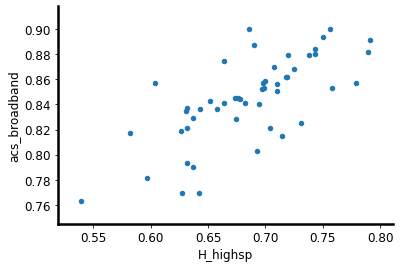

In [60]:
acs_cps_state.plot(kind = "scatter", x = "H_highsp", y = "acs_broadband")
acs_cps_state.corr().acs_broadband.sort_values(ascending = False)

### Cities

In [61]:
city_access = access(cps_city, "city")
city_access.sort_values("H_at_home", ascending = False, inplace = True)
city_access.style.background_gradient(cmap = "viridis", axis = 0)

,H_at_home,H_mobdat,H_highsp,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available,cps_population,N,P_at_home,P_at_work,P_anywhere,P_smartphone,P_computer,P_email,P_text,P_social,P_video,P_services
city,,,,,,,,,,,,,,,,,,
Austin,0.922000,0.911000,0.826000,0.139000,0.572000,0.000000,772743.135000,191,0.845000,0.460000,0.928000,0.841000,0.746000,0.982000,0.987000,0.712000,0.864000,0.600000
Dallas,0.901000,0.889000,0.788000,0.464000,0.452000,0.000000,949174.713000,218,0.783000,0.376000,0.843000,0.821000,0.527000,0.929000,0.977000,0.768000,0.837000,0.493000
San Jose,0.897000,0.853000,0.861000,0.118000,0.737000,0.145000,712351.707000,176,0.853000,0.500000,0.871000,0.800000,0.743000,0.979000,0.947000,0.702000,0.887000,0.554000
Seattle,0.871000,0.820000,0.783000,0.157000,0.615000,0.000000,724611.591000,192,0.831000,0.565000,0.918000,0.768000,0.720000,0.935000,0.928000,0.690000,0.962000,0.729000
Washington,0.853000,0.822000,0.795000,0.253000,0.533000,0.022000,675022.827000,1560,0.825000,0.497000,0.873000,0.767000,0.712000,0.948000,0.957000,0.781000,0.865000,0.789000
Denver,0.833000,0.752000,0.781000,0.273000,0.416000,0.134000,766922.591000,179,0.777000,0.421000,0.829000,0.753000,0.655000,0.975000,0.964000,0.838000,0.873000,0.626000
Charlotte,0.825000,0.756000,0.722000,0.414000,0.430000,0.000000,692284.960000,169,0.736000,0.273000,0.786000,0.719000,0.585000,0.849000,0.887000,0.633000,0.711000,0.346000
Jacksonville,0.822000,0.746000,0.671000,0.244000,0.656000,0.000000,884801.992000,221,0.740000,0.292000,0.788000,0.698000,0.634000,0.905000,0.962000,0.850000,0.754000,0.261000
Fort Worth,0.808000,0.804000,0.700000,0.331000,0.345000,0.114000,1085204.741000,241,0.694000,0.309000,0.828000,0.679000,0.537000,0.830000,0.971000,0.731000,0.799000,0.211000


The fact that SF is low still feels really weird.

In [62]:
sf = cps.query("(gestfips == 6) & (gtcbsa == 41860) & (gtcbsast == 1) & (gtco == 75) & (gtindvpc == 1)")
sf_internet = sf.query("(heinhome == 1) & isHouseholder").hwhhwgt.sum() / sf.query("isHouseholder").hwhhwgt.sum()

sf_internet

0.6540205571069156

Let's just check in on the standard errors... https://cps.ipums.org/cps/repwt.shtml#q40

In [63]:
hh               = sf.query("isHouseholder").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()
hh_with_internet = sf.query("(heinhome == 1) & isHouseholder").filter(regex = "hhwgt[1-9]\d*", axis = 1).sum()

sf_internet_reps = hh_with_internet / hh

np.sqrt((4 / 160) * ((sf_internet_reps - sf_internet)**2).sum())

0.049732365088150265

It's big -- 5% -- but it hardly explains away the "discrepancy."

In [64]:
city_access.index = city_access.index.str.lower().str.replace(" ", "_")

acs_city = pd.read_csv("data/acs_city_access.csv", index_col = "place")
acs_city.rename(columns = {"total_pop" : "acs_population"}, inplace = True)

cps_vs_acs = city_access.join(acs_city)

city
san_jose         0.691524
dallas           0.705666
charlotte        0.793444
austin           0.801399
phoenix          0.879178
san_diego        0.894913
houston          0.902199
chicago          0.903812
san_francisco    0.904823
new_york         0.941778
washington       0.960948
seattle          0.972700
jacksonville     0.978876
los_angeles      0.993651
philadelphia     1.011695
columbus         1.020140
denver           1.070385
indianapolis     1.073466
san_antonio      1.153237
fort_worth       1.207233
Name: pop_ratio, dtype: float64

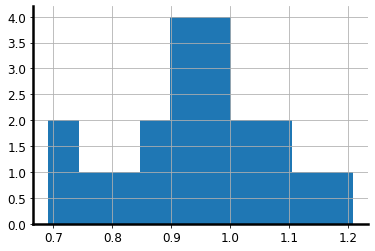

In [65]:
cps_vs_acs["pop_ratio"] = cps_vs_acs["cps_population"] / cps_vs_acs["acs_population"]
cps_vs_acs.pop_ratio.hist()
cps_vs_acs.pop_ratio.sort_values()

,H_at_home,acs_broadband
city,,
dallas,0.901,0.782
philadelphia,0.742,0.798
indianapolis,0.656,0.812
chicago,0.740,0.817
san_antonio,0.768,0.817
houston,0.711,0.836
new_york,0.754,0.840
los_angeles,0.780,0.856
phoenix,0.750,0.857


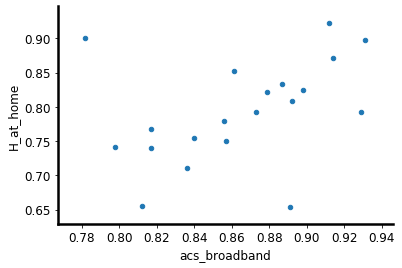

In [36]:
cps_vs_acs.plot(kind = "scatter", x = "acs_broadband", y = "H_at_home")
cps_vs_acs[["H_at_home", "acs_broadband"]].sort_values(by = "acs_broadband")

### CBSA

In [190]:
cps_cbsa_agg = access(cps_cbsa, "cbsa")
cps_cbsa_agg.sort_values("H_at_home").style.background_gradient(cmap = "viridis", axis = 0)

,H_at_home,H_mobdat,H_highsp,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available,cps_population,N,P_at_home,P_at_work,P_anywhere,P_smartphone,P_computer,P_email,P_text,P_social,P_video,P_services
cbsa,,,,,,,,,,,,,,,,,,
Detroit,0.753000,0.673000,0.634000,0.122000,0.669000,0.000000,4101904.538000,1069,0.689000,0.285000,0.733000,0.649000,0.555000,0.890000,0.923000,0.698000,0.701000,0.302000
Miami,0.768000,0.719000,0.696000,0.147000,0.702000,0.000000,6444788.400000,1564,0.702000,0.310000,0.760000,0.679000,0.584000,0.907000,0.944000,0.711000,0.653000,0.347000
Los Angeles,0.775000,0.740000,0.646000,0.198000,0.566000,0.038000,12579565.767000,3420,0.684000,0.271000,0.744000,0.677000,0.532000,0.883000,0.930000,0.754000,0.772000,0.482000
Houston,0.777000,0.735000,0.666000,0.246000,0.581000,0.021000,6789248.872000,1535,0.711000,0.288000,0.756000,0.673000,0.530000,0.905000,0.937000,0.725000,0.773000,0.332000
Tampa,0.783000,0.603000,0.746000,0.262000,0.554000,0.025000,2928313.477000,798,0.718000,0.319000,0.785000,0.659000,0.601000,0.949000,0.873000,0.718000,0.671000,0.286000
Atlanta,0.787000,0.731000,0.671000,0.245000,0.603000,0.043000,5792561.413000,1432,0.750000,0.325000,0.797000,0.710000,0.622000,0.938000,0.936000,0.699000,0.746000,0.411000
New York,0.787000,0.717000,0.731000,0.151000,0.627000,0.007000,19249568.003000,4724,0.729000,0.312000,0.779000,0.679000,0.577000,0.904000,0.926000,0.719000,0.713000,0.409000
San Diego,0.790000,0.692000,0.695000,0.229000,0.541000,0.076000,3303635.443000,827,0.731000,0.335000,0.806000,0.707000,0.620000,0.912000,0.927000,0.736000,0.780000,0.523000
Riverside,0.794000,0.753000,0.702000,0.211000,0.638000,0.023000,4477690.696000,1083,0.715000,0.264000,0.765000,0.683000,0.520000,0.877000,0.927000,0.775000,0.743000,0.324000


In [201]:
cbsa_dict = {
    35620 : "New York", 31080 : "Los Angeles", 16980 : "Chicago", 19100 : "Dallas-Fort Worth", 26420 : "Houston", 
    37980 : "Philadelphia", 47900 : "Washington", 33100 : "Miami", 12060 : "Atlanta", 14460 : "Boston", 
    41860 : "San Francisco", 40140 : "Riverside", 38060 : "Phoenix", 19820 : "Detroit", 42660 : "Seattle", 
    33460 : "Minneapolis", 41740 : "San Diego", 45300 : "Tampa", 41180 : "St Louis", 12580 : "Baltimore"
}

acs_cbsa = pd.read_csv("data/acs_cbsa_access.csv")
acs_cbsa.query("GEOID in @cbsa_dict", inplace = True)
acs_cbsa["cbsa"] = acs_cbsa.GEOID.replace(cbsa_dict)
acs_cbsa.set_index("cbsa", inplace = True)
acs_cbsa.rename(columns = {"total_pop" : "acs_population"}, inplace = True)

cps_acs_cbsa = cps_cbsa_agg.join(acs_cbsa)

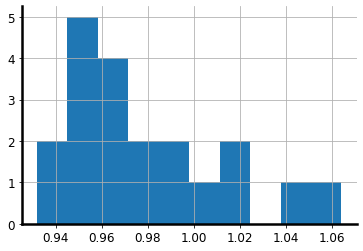

In [202]:
cps_acs_cbsa["pop_ratio"] = cps_acs_cbsa["cps_population"] / cps_acs_cbsa["acs_population"]
cps_acs_cbsa.pop_ratio.hist()

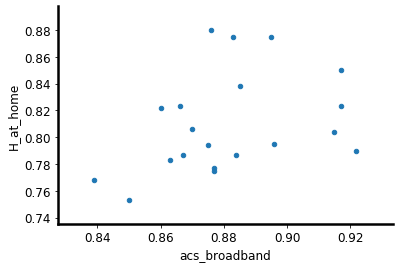

In [205]:
cps_acs_cbsa[["H_at_home", "acs_broadband"]].sort_values(by = "acs_broadband")
cps_acs_cbsa.plot(kind = "scatter", x = "acs_broadband", y = "H_at_home")

In [ ]:
city_access.index = city_access.index.str.lower().str.replace(" ", "_")

acs_city = pd.read_csv("data/acs_city_access.csv", index_col = "place")
acs_city.rename(columns = {"total_pop" : "acs_population"}, inplace = True)

cps_vs_acs = city_access.join(acs_city)

In [59]:
cps_acs_cbsa.corr().acs_broadband.sort_values(ascending = False)

acs_broadband               1.000000
H_nonuse_not_available      0.781450
P_video                     0.754884
P_services                  0.733436
P_email                     0.578830
P_at_work                   0.537904
P_computer                  0.492555
P_smartphone                0.473596
P_at_home                   0.440489
P_anywhere                  0.437121
H_at_home                   0.351372
H_mobdat                    0.339974
H_highsp                    0.287963
GEOID                       0.287909
P_text                      0.248284
P_social                    0.010837
H_nonuse_cost              -0.030624
acs_broadband_households   -0.185636
acs_households             -0.215506
H_nonuse_no_interest       -0.586889
Name: acs_broadband, dtype: float64

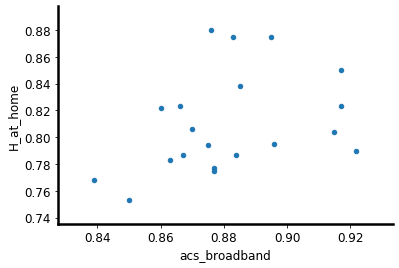

In [62]:
cps_acs_cbsa.plot(kind = "scatter", x = "acs_broadband", y = "H_at_home")

In [67]:
why_no_net = {
  1  : "Don't need it or not interested",
  2  : "Can't afford it",
  3  : "Not worth the cost",
  4  : "Can use it elsewhere",
  5  : "Not available in area",
  6  : "No device",
  7  : "Privacy or security concerns",
  8  : "Safety concerns",
  9  : "Moving",
  10 : "Other",
  -1 : "NA"
}

cps["why_no_net"] = cps.heprinoh.replace(why_no_net)

(cps.query("heprinoh > 0").groupby("why_no_net").hwhhwgt.sum().sort_values(ascending = False) / 1e6).round(2)

why_no_net
Don't need it or not interested    30.09
Can't afford it                     9.14
Other                               4.74
Not available in area               2.03
Can use it elsewhere                1.79
No device                           1.36
Not worth the cost                  1.31
Privacy or security concerns        0.79
Moving                              0.20
Safety concerns                     0.19
Name: hwhhwgt, dtype: float64

In [18]:
# print([x for x in cps.columns if "wgt" not in x])

### CSA doesn't work.... 

Missing: 288 houston, 420 phoenix, 476 st louis

In [19]:
csa = {"new_york" : 408, "los_angeles" : 348, "chicago" : 176, "washington" : 548, "san_jose" : 488, 
       "boston" : 148, "dallas-fort_worth" : 206, "houston" : 288, "philadelphia" : 428, "miami" : 370,
       "atlanta" : 122, "detroit" : 220, "phoenix" : 429, "seattle" : 500, "orlando" : 422, 
       "minneapolis" : 378, "denver" : 216, "cleveland" : 184, "portland" : 440, "st_louis" : 476}